In [179]:
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo
import matplotlib.pyplot as plt
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

sns.set(font_scale = 1.5)

task = 'in-hospital-mortality'
mimic3_path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir), 'data')

In [156]:
FRIENDLY_LABELS = {
    "GENDER": {0: "Female", 1: "Male"}, # 0: female, 1: male
    "ETHNICITY": {0: "Non-white", 1: "White"}, # 0: mon-white, 1: white
    "LANGUAGE": {0: "Non-English", 1: "English"},  # 0 non-english speakers, 1: english speakers
    "INSURANCE": {0: "Uninsured", 1: "Insured"},  # 0: public or no insurance, 1: private insurance
    "RELIGION": {0: "Non-christian", 1: "Christian"},  # 0: non-christian, 1: christian
    "AGE": {0: "65+", 1: "<65"}  # 0: 65+, 1: <65
}

In [157]:
train = pd.read_csv(os.path.join(mimic3_path, task, 'train_listfile.csv'))
test = pd.read_csv(os.path.join(mimic3_path, task, 'test_listfile.csv'))
val = pd.read_csv(os.path.join(mimic3_path, task, 'val_listfile.csv'))
print("Train rows: {} - Validation rows: {} - Test rows: {}".format(train.shape[0], val.shape[0], test.shape[0]))

Train rows: 14681 - Validation rows: 3222 - Test rows: 3236


In [158]:
df = pd.concat([train, test, val])
print("Total rows: {}".format(df.shape[0]))
print(df.head(100))

Total rows: 21139
                             stay  y_true
0   12797_episode1_timeseries.csv       0
1    9027_episode1_timeseries.csv       0
2   40386_episode1_timeseries.csv       0
3   48770_episode1_timeseries.csv       0
4   14037_episode1_timeseries.csv       0
5   15656_episode1_timeseries.csv       1
6   83338_episode1_timeseries.csv       1
7   21827_episode2_timeseries.csv       0
8   20226_episode1_timeseries.csv       0
9   26578_episode1_timeseries.csv       1
10   9200_episode1_timeseries.csv       1
11  15881_episode1_timeseries.csv       0
12  59005_episode1_timeseries.csv       0
13  14276_episode1_timeseries.csv       1
14  81660_episode1_timeseries.csv       0
15  28279_episode1_timeseries.csv       0
16  15259_episode1_timeseries.csv       1
17  24133_episode1_timeseries.csv       0
18  92525_episode1_timeseries.csv       0
19  28068_episode1_timeseries.csv       0
20  72540_episode1_timeseries.csv       0
21  53534_episode1_timeseries.csv       0
22   1313_episod

In [159]:
# extract subject_id from stay
regex = r"(?:^\d+)"
df.loc[:, "SUBJECT_ID"] = df.stay.apply(lambda stay: re.search(regex, stay).group(0))
df.SUBJECT_ID = df.SUBJECT_ID.astype(int)
df.drop(['stay'], axis=1, inplace=True)
print(df.head(100))

    y_true  SUBJECT_ID
0        0       12797
1        0        9027
2        0       40386
3        0       48770
4        0       14037
5        1       15656
6        1       83338
7        0       21827
8        0       20226
9        1       26578
10       1        9200
11       0       15881
12       0       59005
13       1       14276
14       0       81660
15       0       28279
16       1       15259
17       0       24133
18       0       92525
19       0       28068
20       0       72540
21       0       53534
22       0        1313
23       0        6630
24       0       22269
25       0       11512
26       0       22384
27       0        6699
28       0       78934
29       0       16522
..     ...         ...
70       1        3340
71       0       14662
72       0       68863
73       1         450
74       0       28654
75       0       31529
76       0       20432
77       0       20577
78       0       52974
79       1       78447
80       1       75544
81       0 

In [160]:
# join with demographics
demographics = pd.read_csv(os.path.join(mimic3_path, 'DEMOGRAPHICS.csv'))
df = df.merge(demographics, how='inner', on='SUBJECT_ID')
print("Total rows after merging: {}".format(df.shape[0]))
print(df.head(100))

Total rows after merging: 21139
    y_true  SUBJECT_ID  LANGUAGE  INSURANCE  RELIGION  ETHNICITY  GENDER  AGE
0        0       12797         1          1         0          1       0    0
1        0        9027         1          1         1          0       1    1
2        0       40386         1          1         1          1       0    0
3        0       48770         1          0         1          1       1    1
4        0       14037         1          1         1          1       1    1
5        1       15656         1          1         1          1       0    0
6        1       83338         1          1         1          1       0    0
7        0       21827         1          1         1          0       1    0
8        0       21827         1          1         1          0       1    0
9        0       20226         1          1         1          1       0    0
10       1       26578         1          1         1          1       1    0
11       1        9200         1

## Is the dataset sample representative of the real-world population?

In [161]:
# real population distributions in 2016 (MIMIC-III release year) in the USA based on wikipedia as of 10/01/2022
# 1 privileged class - 0 unprivileged class
REAL_DISTRIBUTIONS = {
    "GENDER": {0: 50.5, 1: 49.5}, # 0: female, 1: male
    "ETHNICITY": {0: 42.2, 1: 61.27}, # 0: mon-white, 1: white (https://www.statista.com/statistics/270272/percentage-of-us-population-by-ethnicities/)
    "LANGUAGE": {0: 21.8, 1: 78.2},  # 0 non-english speakers, 1: english speakers (https://en.wikipedia.org/wiki/Languages_of_the_United_States)
    "INSURANCE": {0: 8.8, 1: 91.2},  # 0: public or no insurance, 1: private insurance (https://www.census.gov/content/dam/Census/library/publications/2017/demo/p60-260.pdf)
    "RELIGION": {0: 26.3, 1: 73.7},  # 0: non-christian, 1: christian (https://www.prri.org/research/american-religious-landscape-christian-religiously-unaffiliated/)
    "AGE": {0: 16.9, 1: 59.6}  # 0: 65+, 1: <65
}

In [162]:
# calculate dataset distributions
dataset_distributions = {
    "GENDER": {0: np.NaN, 1: np.NaN}, # 0: female, 1: male
    "ETHNICITY": {0: np.NaN, 1: np.NaN}, # 0: mon-white, 1: white
    "LANGUAGE": {0: np.NaN, 1: np.NaN},  # 0 non-english speakers, 1: english speakers
    "INSURANCE": {0: np.NaN, 1: np.NaN},  # 0: public or no insurance, 1: private insurance
    "RELIGION": {0: np.NaN, 1: np.NaN},  # 0: non-christian, 1: christian
    "AGE": {0: np.NaN, 1: np.NaN}  # 0: 65+, 1: <65
}

for attribute in REAL_DISTRIBUTIONS:
    counts = df[attribute].value_counts()
    dataset_distributions.get(attribute).update(counts)

print(dataset_distributions)

{'GENDER': {0: 9510, 1: 11629}, 'ETHNICITY': {0: 6134, 1: 15005}, 'LANGUAGE': {0: 1829, 1: 19310}, 'INSURANCE': {0: 182, 1: 20957}, 'RELIGION': {0: 3230, 1: 17909}, 'AGE': {0: 11588, 1: 9551}}


In [163]:
real_ratios = []
dataset_ratios = []
ratios = pd.DataFrame(columns=['attribute', 'real_ratio', 'dataset_ratio'])
for attr in REAL_DISTRIBUTIONS.keys():
    attr_ratio = list(REAL_DISTRIBUTIONS.get(attr).values())[0] / list(REAL_DISTRIBUTIONS.get(attr).values())[1]
    dataset_ratio = list(dataset_distributions.get(attr).values())[0] / \
                        list(dataset_distributions.get(attr).values())[1]

    real_ratios.append(attr_ratio)
    dataset_ratios.append(dataset_ratio)

ratios["attribute"] = REAL_DISTRIBUTIONS.keys()
ratios["real_ratio"] = real_ratios
ratios["dataset_ratio"] = dataset_ratios
ratios.head(10)

,attribute,real_ratio,dataset_ratio
0,GENDER,1.020202,0.817783
1,ETHNICITY,0.688755,0.408797
2,LANGUAGE,0.278772,0.094718
3,INSURANCE,0.096491,0.008684
4,RELIGION,0.356852,0.180356
5,AGE,0.283557,1.213276


In [164]:
categories = ratios.attribute
categories = [*categories, categories[0]]

real_ratio = ratios.real_ratio
dataset_ratio = ratios.dataset_ratio
real_ratio = [*real_ratio, real_ratio[0]]
dataset_ratio = [*dataset_ratio, dataset_ratio[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=real_ratio, theta=categories, name='Real Ratios'),
        go.Scatterpolar(r=dataset_ratio, theta=categories, name='Dataset Ratios'),
    ],
    layout=go.Layout(
        title=go.layout.Title(
            text='Real vs Dataset Population Ratio Comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True,
        margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=70, #top margin
        ),
        template='seaborn',
    )
)
fig['data'][0]['line']['color']="#e72a8a"
fig['data'][1]['line']['color']="#1c9e77"
fig.update_layout(width=int(800))
                  # , paper_bgcolor="rgba(0,0,0,0)")
pyo.iplot(fig)
output_path = "img"
if not os.path.exists(output_path):
    os.makedirs(output_path)
fig.write_image(os.path.join(output_path, "representationRadar.pdf"), engine="kaleido")

## Are there underrepresented populations?

In [165]:
df

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,0,12797,1,1,0,1,0,0
1,0,9027,1,1,1,0,1,1
2,0,40386,1,1,1,1,0,0
3,0,48770,1,0,1,1,1,1
4,0,14037,1,1,1,1,1,1
5,1,15656,1,1,1,1,0,0
6,1,83338,1,1,1,1,0,0
7,0,21827,1,1,1,0,1,0
8,0,21827,1,1,1,0,1,0
9,0,20226,1,1,1,1,0,0


In [166]:
count_df = pd.concat(axis=0, ignore_index=True, objs=[
    df[protected_attribute].value_counts().reset_index(drop=False) for protected_attribute in REAL_DISTRIBUTIONS.keys()
])
count_df = count_df.melt('index')
count_df.dropna(axis=0, inplace=True)
count_df.reset_index(inplace=True, drop=True)
# count_df["majority"] = np.where(count_df.index % 2, 0, 1)
count_df.loc[:, "label"] = count_df.apply(lambda row: FRIENDLY_LABELS.get(row['variable']).get(row['index']), axis=1)
count_df

C:\Users\syfan\PycharmProjects\mimic3-benchmarks\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,index,variable,value,label
0,0,AGE,11588.0,65+
1,1,AGE,9551.0,<65
2,1,ETHNICITY,15005.0,White
3,0,ETHNICITY,6134.0,Non-white
4,1,GENDER,11629.0,Male
5,0,GENDER,9510.0,Female
6,1,INSURANCE,20957.0,Insured
7,0,INSURANCE,182.0,Uninsured
8,1,LANGUAGE,19310.0,English
9,0,LANGUAGE,1829.0,Non-English


In [167]:
FRIENDLY_LABELS.get("GENDER").get(0)

'Female'

C:\Users\syfan\PycharmProjects\mimic3-benchmarks\venv\lib\site-packages\seaborn\categorical.py:3200: UserWarning:

Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.



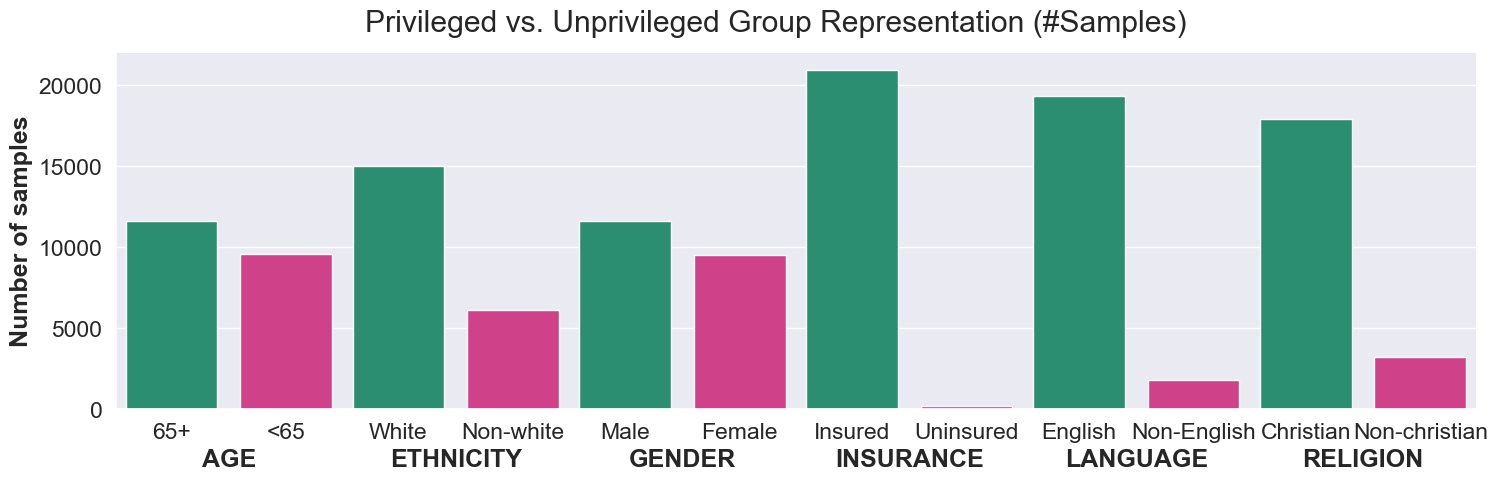

In [181]:
# sns.set_style('whitegrid')
# sns.set(font_scale = 1.5)
g = sns.catplot(data=count_df[count_df.index.notnull()], x="label", col="variable", y="value", kind='bar', sharex=False, palette=['#1c9e77', '#e72a8a'], aspect=.5)
g.set_titles("{col_name}")
g.set_ylabels('Number of samples')
g.set_xlabels('Protected Attribute')
plt.suptitle("Privileged vs. Unprivileged Group Representation (#Samples)")
for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_title())
    ax.set_title('')
    ax.margins(x=0.05) # slightly more margin as a separation
plt.subplots_adjust(wspace=0, bottom=0.18, left=0.06)
# plt.legend(labels=['Majority Segment', 'Minority Segment'], labelcolor=['#1c9e77', '#e72a8a'])
# plt.show()
plt.savefig('./img/representationBar.pdf', format='pdf', bbox_inches="tight")
plt.savefig('./img/representationBar.png')

## Are there imbalances in the labels across groups, i.e., unevenly sampled populations?

In [169]:
df

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,0,12797,1,1,0,1,0,0
1,0,9027,1,1,1,0,1,1
2,0,40386,1,1,1,1,0,0
3,0,48770,1,0,1,1,1,1
4,0,14037,1,1,1,1,1,1
5,1,15656,1,1,1,1,0,0
6,1,83338,1,1,1,1,0,0
7,0,21827,1,1,1,0,1,0
8,0,21827,1,1,1,0,1,0
9,0,20226,1,1,1,1,0,0


In [170]:
dataset = StandardDataset(df,
                          label_name='y_true',
                          favorable_classes=[0],  # non-mortality is the favorable outcome
                          protected_attribute_names=list(REAL_DISTRIBUTIONS.keys()),
                          privileged_classes=[[0], [0], [0], [0], [0], [0]])

bias_columns_metric = pd.DataFrame(columns=['protected_attribute', 'mean_difference', 'disparate_impact_ratio'])
for attr in dataset.protected_attribute_names:
    print("\nEvaluating Outcome Bias for {}".format(attr))
    idx = dataset.protected_attribute_names.index(attr)
    privileged_groups = [{attr: dataset.privileged_protected_attributes[idx][0]}]
    unprivileged_groups = [{attr: dataset.unprivileged_protected_attributes[idx][0]}]

    metric_data = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
    bias_columns_metric.loc[len(bias_columns_metric.index)] = [attr, metric_data.mean_difference(), metric_data.disparate_impact()]
    print("Group Fairness - Mean Difference: {}".format(metric_data.mean_difference()))
    print("Group Fairness - Disparate Impact Ratio: {}".format(metric_data.disparate_impact()))
bias_columns_metric.head(10)


Evaluating Outcome Bias for GENDER
Group Fairness - Mean Difference: 0.004718858425204919
Group Fairness - Disparate Impact Ratio: 1.0054547640237874

Evaluating Outcome Bias for ETHNICITY
Group Fairness - Mean Difference: 0.010422838077993157
Group Fairness - Disparate Impact Ratio: 1.0121155370040573

Evaluating Outcome Bias for LANGUAGE
Group Fairness - Mean Difference: 0.002990543912606558
Group Fairness - Disparate Impact Ratio: 1.003457461957116

Evaluating Outcome Bias for INSURANCE
Group Fairness - Mean Difference: 0.038345130557756346
Group Fairness - Disparate Impact Ratio: 1.0462173096788852

Evaluating Outcome Bias for RELIGION
Group Fairness - Mean Difference: 0.0038822343505789947
Group Fairness - Disparate Impact Ratio: 1.0044912668167514

Evaluating Outcome Bias for AGE
Group Fairness - Mean Difference: 0.06183297109603303
Group Fairness - Disparate Impact Ratio: 1.0736327683753808


,protected_attribute,mean_difference,disparate_impact_ratio
0,GENDER,0.004719,1.005455
1,ETHNICITY,0.010423,1.012116
2,LANGUAGE,0.002991,1.003457
3,INSURANCE,0.038345,1.046217
4,RELIGION,0.003882,1.004491
5,AGE,0.061833,1.073633


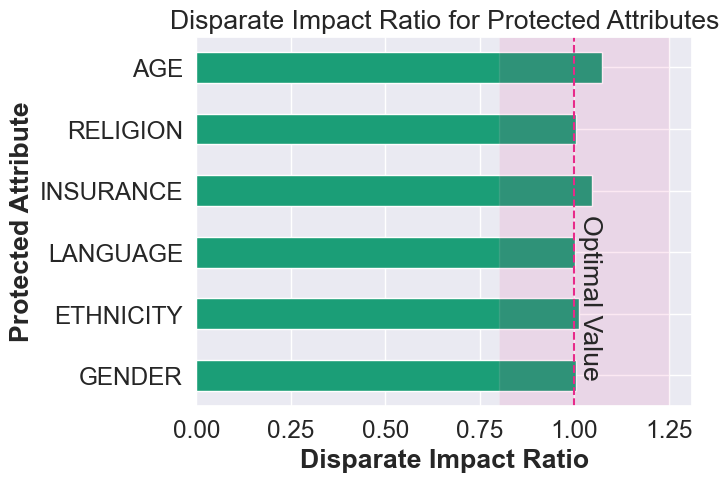

In [171]:
# plt.rcParams.update({'font.size': 15})
# plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax = bias_columns_metric[['protected_attribute', 'disparate_impact_ratio']].plot(kind='barh', colormap='Dark2')
ax.set_ylabel('Protected Attribute')
ax.set_xlabel('Disparate Impact Ratio')
ax.get_legend().remove()
ax.set_yticklabels(bias_columns_metric['protected_attribute'])

plt.axvline(x=1.0, color='#e72a8a', linestyle='--')
plt.axvspan(0.8, 1.25, facecolor='#e72a8a', alpha=0.1)
plt.text(1.01,0,'Optimal Value', rotation=270)
plt.title("Disparate Impact Ratio for Protected Attributes")
plt.savefig('./img/representationDIR.pdf', format='pdf', bbox_inches="tight")
plt.savefig('./img/representationDIR.png', bbox_inches="tight")
# plt.show()